# Examining Lifted E-processes for Testing Exchangeability under the Alternative

Here, we examine whether the e-lifted (and combined) e-processes grow quickly against certain alternatives.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import os

import ecombine as ec

In [2]:
# basic figure styles
ec.set_theme()

# rng for (randomized) inference methods
rng = np.random.default_rng(92304202)
# rng seed for data generator
rng_data_seed = 20240329

# plots saved here
plots_dir = "./plots/exch/alt"
plot_fmt = "pdf"
os.makedirs(plots_dir, exist_ok=True)
mpl.rc("savefig", format=plot_fmt, dpi=300)

### Setup

In [3]:
# sequence length
T = 2500

# data rng
rng_data = np.random.default_rng(rng_data_seed)

In [4]:
n_repeats = 1000    # number of repeated runs
avg_weight0 = 0.5   # averaging weight ('gamma' in paper)
errorbar = None

# conformal hyperparams
jump = 0.01
jumper_weights = (1/3, 1/3, 1/3)

In [5]:
def plot_binary_data_mean(x, title="cumulative mean", ylim=(0, 1)):
    """Plot the running average of binary data."""
    ax = sns.lineplot(
        data={
            "t": np.arange(1, T+1),
            r"$\hat{p}_t$": ec.cumul_mean(x),
        },
        x="t",
        y=r"$\hat{p}_t$",
    )
    ax.set(
        title=title,
        ylabel="cumulative mean, " + r"$\hat{p}_t$",
        ylim=ylim,
    )
    return ax

### Changepoint Alternative (one "shock")

Conformal test martingales grow quickly against changepoint alternatives.

The following data has a changepoint from $Ber(p)$ to $Ber(q)$ after `0.2*T` (500) time steps, for a duration of `0.04*T` (100), before switching back to $Ber(p)$.

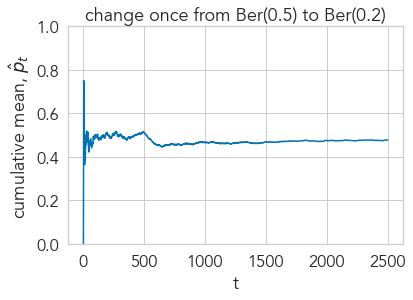

In [6]:
p, q = 0.5, 0.2
change_loc = 0.2
change_len = 0.04

# p, q = 0.5, 0.2
# change_loc = 0.15
# change_len = 0.05

x_change1 = ec.data.exch.generate_binary_changepoint(
    p=p, q=q, size=T, change_loc=change_loc, change_len=change_len,
    rng=rng_data)
_ = plot_binary_data_mean(x_change1, title=f"change once from Ber({p}) to Ber({q})")

We compute the UI, conformal, and combined (via e-lifting) e-processes across repeated trials.

In [7]:
# generate data & e-processes
data_generator = lambda T: ec.data.exch.generate_binary_changepoint(
    p=p, q=q, size=T, change_loc=change_loc, change_len=change_len,
    rng=rng_data,
)
eprocess_fns = {
    "UI": ec.eprocess_exch_universal,
    "Conformal": lambda x: ec.eprocess_exch_conformal(
        x, jump=jump, jumper_weights=jumper_weights, rng=rng
    ),
}
lift = (False, True)

df = ec.compute_e_combined(
    data_generator,
    eprocess_fns["UI"],
    eprocess_fns["Conformal"],
    lift=lift,
    avg_weight0=avg_weight0,
    n_repeats=n_repeats,
    T=T,
)

compute_e_combined repeated trials: 100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.45it/s]


In [8]:
# wide -> tall
mdf = pd.melt(
    df.drop(columns=["id", "x"]), 
    id_vars=["Time"], 
    var_name="E-process", 
    value_name="Value",
)
mdf["E-process"] = mdf["E-process"].replace({
    "e0": "UI", 
    "e1": "Conformal",
    "ec": "eLift+Avg",
})

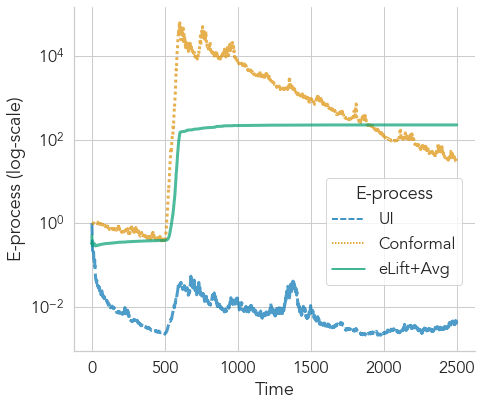

In [9]:
fg = ec.plot_eprocess_from_df(
    mdf, 
    title="",
    style_order=["eLift+Avg", "UI", "Conformal"],
    linewidth=3,
    aspect=1.2, 
    height=6,
    errorbar=errorbar,
    facet_kws={"legend_out": False},
)
sns.move_legend(fg, loc=(0.675, 0.3))
fg.savefig(os.path.join(plots_dir, f"combined_change1_p{p}_q{q}.{plot_fmt}"))

### Two "shocks" of change

The following data has two brief periods of change from $Ber(p)$ to $Ber(q)$.
Specifically: the first 40% of the data comes from $Ber(p)$; the next 10% comes from $Ber(q)$; the next 40% comes from $Ber(p)$; and the final 10% comes from $Ber(q)$.

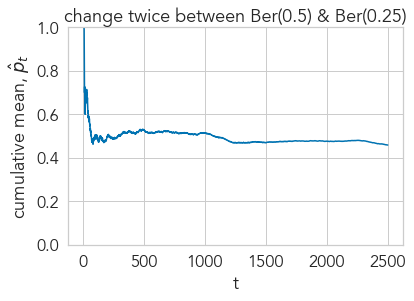

In [10]:
p, q = 0.5, 0.25
# p, q = 0.01, 0.05

x_change2 = ec.data.exch.generate_binary_change_twice(
    p=p, q=q, size=T, rng=rng_data)
_ = plot_binary_data_mean(x_change2, title=f"change twice between Ber({p}) & Ber({q})")

In [11]:
# generate data & e-processes
data_generator = lambda T: (
    ec.data.exch.generate_binary_change_twice(
        p=p, q=q, size=T, rng=rng_data
    ))
eprocess_fns = {
    "UI": ec.eprocess_exch_universal,
    "Conformal": lambda x: ec.eprocess_exch_conformal(
        x, jump=jump, jumper_weights=jumper_weights, rng=rng
    ),
}
lift = (False, True)

df = ec.compute_e_combined(
    data_generator,
    eprocess_fns["UI"],
    eprocess_fns["Conformal"],
    lift=lift,
    avg_weight0=avg_weight0,
    n_repeats=n_repeats,
    T=T,
)

compute_e_combined repeated trials: 100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:45<00:00, 22.21it/s]


In [12]:
# wide -> tall
mdf = pd.melt(
    df.drop(columns=["id", "x"]), 
    id_vars=["Time"], 
    var_name="E-process", 
    value_name="Value",
)
mdf["E-process"] = mdf["E-process"].replace({
    "e0": "UI", 
    "e1": "Conformal",
    "ec": "eLift+Avg",
})

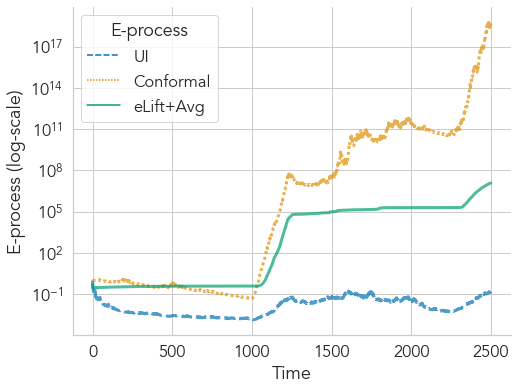

In [13]:
fg = ec.plot_eprocess_from_df(
    mdf, 
    title="",
    style_order=["eLift+Avg", "UI", "Conformal"],
    linewidth=3,
    aspect=1.2, 
    height=6,
    errorbar=errorbar,
    facet_kws={"legend_out": False},
)
fg.savefig(os.path.join(plots_dir, f"combined_change2_p{p}_q{q}.{plot_fmt}"))

### First-Order Markov

UI e-processes grow quickly against Markovian alternatives; conformal e-processes may not.

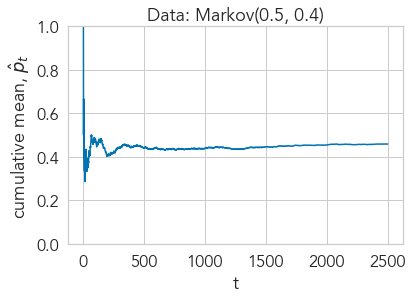

In [14]:
# p_kj: transition prob from j to k
p_10, p_11 = 0.5, 0.4

x_markov = ec.data.exch.generate_binary_markov(
    p_10=p_10, p_11=p_11, size=T, rng=rng_data)
_ = plot_binary_data_mean(x_markov, title=f"Data: Markov({p_10}, {p_11})")

In [15]:
# generate data & e-processes
data_generator = lambda T: (
    ec.data.exch.generate_binary_markov(
        p_10=p_10, p_11=p_11, size=T, rng=rng_data
    )
)
eprocess_fns = {
    "UI": ec.eprocess_exch_universal,
    "Conformal": lambda x: ec.eprocess_exch_conformal(
        x, jump=jump, jumper_weights=jumper_weights, rng=rng
    ),
}
lift = (False, True)

df = ec.compute_e_combined(
    data_generator,
    eprocess_fns["UI"],
    eprocess_fns["Conformal"],
    lift=lift,
    avg_weight0=avg_weight0,
    n_repeats=n_repeats,
    T=T,
)

compute_e_combined repeated trials: 100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:48<00:00, 20.54it/s]


In [16]:
# wide -> tall
mdf = pd.melt(
    df.drop(columns=["id", "x"]), 
    id_vars=["Time"], 
    var_name="E-process", 
    value_name="Value",
)
mdf["E-process"] = mdf["E-process"].replace({
    "e0": "UI", 
    "e1": "Conformal",
    "ec": "eLift+Avg",
})

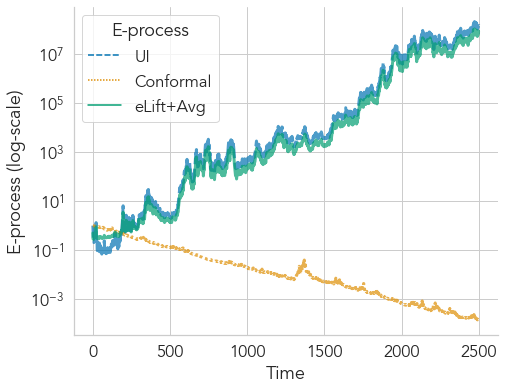

In [17]:
fg = ec.plot_eprocess_from_df(
    mdf, 
    title="",
    style_order=["eLift+Avg", "UI", "Conformal"],
    linewidth=3,
    aspect=1.2, 
    height=6,
    errorbar=errorbar,
    facet_kws={"legend_out": False},
)
fg.savefig(os.path.join(plots_dir, f"combined_markov_{p_10}_{p_11}.{plot_fmt}"))